In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 

# Import the Stock Market Index from NASDAQ Composite
    I chose NASDAQ Composite because it takes into account 4000+ companies. Unlike the SP500 which only analyze the top 500 companies and Dow Jones Industrial Average which only analyze the top 30 companies. I think with more companies being factor into the Stock Market Index, it will have less bias in the analysis. Another reason being that NASDAQ is also the first all-electronic stock exchange. NASDAQ also focus more on the Tech. Companies, which is a personal perference.
    
https://www.fool.com/investing/general/2014/07/08/whats-the-difference-between-the-dow-the-nasdaq-an.aspx

##### Data:
https://finance.yahoo.com/quote/NDAQ/history?p=NDAQ
I set the time period from 2008 - 2018, 10 years

In [2]:
# parse date
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# import NASDAQ.csv
nas = pd.read_csv('NASDAQ.csv', parse_dates = ['Date'], index_col = 'Date', date_parser = dateparse)

In [3]:
print(nas.dtypes)
print('\nData Dimension:', nas.shape)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Data Dimension: (2519, 6)


In [4]:
# conversion to Julian Date
def Julian(dat):

    Julian_Date = []

    for date in dat:
        Julian_Date.append(pd.Timestamp.to_julian_date(date))
        
    return Julian_Date

    Create a function to convert the 'Date' to 'Julian Date' for graph purposes. The type of 'Date' is Timestamp, difficult to use it in a plot. Conver to 'Julian Date' will change the type to Float, which makes it easier to plot.
$$ Date => Timestamp => Julian Date $$

# Learn about the Stock Market Index

In [5]:
nas.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-04-28,2422.629883,2437.000000,2416.899902,2424.399902,2424.399902,1724680000
2008-04-29,2420.000000,2435.379883,2412.100098,2426.100098,2426.100098,1769030000
2008-04-30,2434.199951,2451.189941,2406.370117,2412.800049,2412.800049,2127390000
2008-05-01,2416.489990,2480.709961,2416.489990,2480.709961,2480.709961,2344770000
2008-05-02,2499.139893,2499.139893,2461.459961,2476.989990,2476.989990,2279510000


In [6]:
# reverse the order of the dates
# start with index [0]  => 2018
# and end with => 2008
nas_df = nas.sort_index(ascending = False)
nas_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-27,7195.520020,7197.149902,7083.950195,7119.799805,7119.799805,2027530000
2018-04-26,7080.490234,7143.939941,7055.660156,7118.680176,7118.680176,2127140000
2018-04-25,7009.990234,7030.740234,6926.970215,7003.740234,7003.740234,2026690000
2018-04-24,7160.770020,7171.669922,6961.520020,7007.350098,7007.350098,2149250000
2018-04-23,7173.990234,7195.720215,7094.430176,7128.600098,7128.600098,1737370000


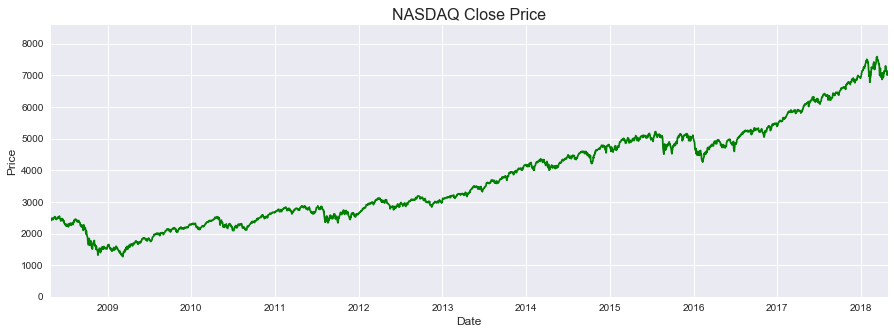

In [7]:
# set the size of the graph
plt.figure(figsize = (15, 5))

# plot a line graph to show the trend of the NASDAQ index
plt.plot(nas_df.index, nas_df.Close, color = 'green')
plt.ylim([0, max(nas.Close)+1000])
plt.xlim([nas_df.index[-1], nas_df.index[0]])
plt.title('NASDAQ Close Price', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Price', fontsize = 12)

plt.savefig('market_trend')
plt.show()

    Observing the Stock Market Index for NASDAQ's closing price for the last decade. We can seet that it has been steadily rising after the Recession that happened in 2008. There were some drops in the line plot, but nothing too siginificant that shows a signs of decline in the market.

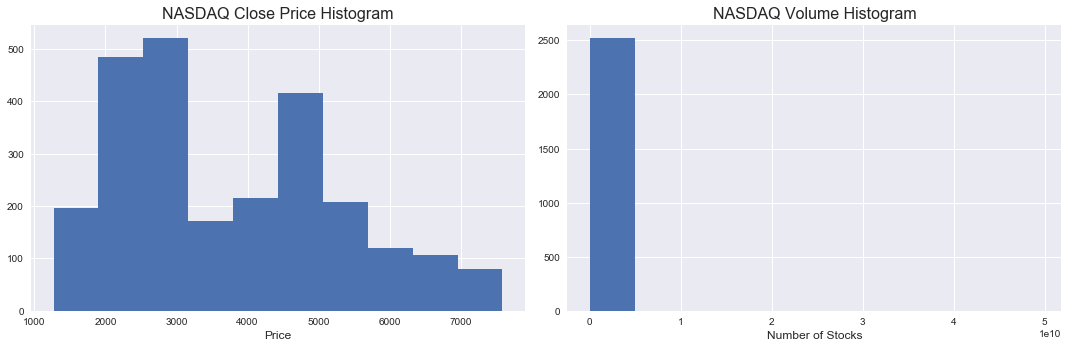

In [8]:
# plot histograms to learn about distribution and identify outliers
# set the size of graph
plt.figure(figsize = (15, 5))

# plot a histogram to see the distribution of the Closing Prices
plt.subplot(1,2,1)
nas_df['Close'].hist()
plt.title('NASDAQ Close Price Histogram', fontsize = 16)
plt.xlabel('Price', fontsize = 12)

# plot a histogram to see the distribution of the Volume of stocks
plt.subplot(1,2,2)
nas_df['Volume'].hist()
plt.title('NASDAQ Volume Histogram', fontsize = 16)
plt.xlabel('Number of Stocks', fontsize = 12)

plt.tight_layout()
plt.savefig('data_preprocess_1')
plt.show()

    Closing Price: looking at the histogram, there does not have any values that stand out to be the outlier
    
    Volumes: it seems there is an outlier, that really mess up the distribution of the histogram. 

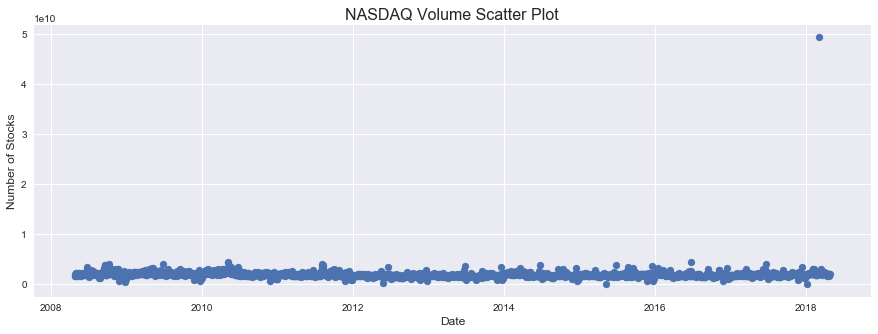

In [9]:
# set the size of graph
plt.figure(figsize = (15, 5))

# plot scatter graph to identify outliers for the Volumes of Stocks
plt.scatter(nas_df.index, nas_df['Volume'])
plt.title('NASDAQ Volume Scatter Plot', fontsize = 16)
plt.ylabel('Number of Stocks', fontsize = 12)
plt.xlabel('Date', fontsize = 12)

plt.savefig('data_preprocess_2')
plt.show()

    In the scatter plot, it looks like the outlier has an extremely high number of stocks sold on that particular day. If the differences are significant, we can safely assume that data is inaccurate. 
    
    Instead of simply droping this row that contains an outlier, I want to replace the value with a more accurate value. My method is to find the number of stocks that were traded within two weeks timespan of the row that contains the outlier. And then use the mean of volumes traded within these two weeks to replace the original value (outlier). My reasoning behind this method is that volume of stocks traded each day within two weeks are not going to be siginficantly different. 

In [10]:
# find the index of the outlier
outlier = nas_df.loc[nas_df.Volume > 1e10]
outlier

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-05,7222.890137,7350.069824,7205.310059,7330.709961,7330.709961,49345880000


In [11]:
# get Volumes from the previous week of and the week after 2018-03-05
# find the mean of the volumes of stocks traded within this two week and replace the outlier value
dat = nas_df.loc[(nas_df.index >= '2018-02-26') & (nas_df.index <= '2018-03-10') & (nas_df.index != '2018-03-05')]
new_Volume = int(dat.Volume.mean())

In [12]:
# replace the outlier
nas_df.replace(to_replace = list(nas_df.ix[outlier.index].Volume),
            value = new_Volume,
            inplace = True)

C:\Users\Mike\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


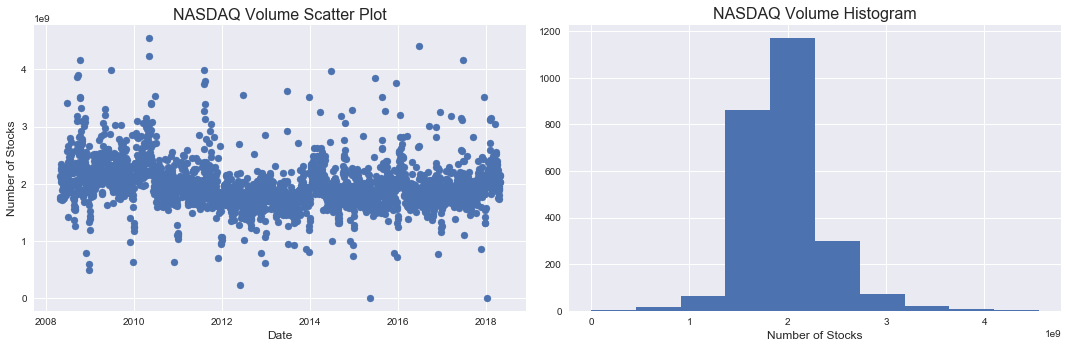

In [13]:
# after replacing the outlier, replot the scatter to identify any other outliers
# set the size of graph
plt.figure(figsize = (15, 5))

# plot scatter graph to identify outliers
plt.subplot(1,2,1)
plt.scatter(nas_df.index, nas_df['Volume'])
plt.title('NASDAQ Volume Scatter Plot', fontsize = 16)
plt.ylabel('Number of Stocks', fontsize = 12)
plt.xlabel('Date', fontsize = 12)

# plot histograms
plt.subplot(1,2,2)
nas_df['Volume'].hist()
plt.title('NASDAQ Volume Histogram', fontsize = 16)
plt.xlabel('Number of Stocks', fontsize = 12)

plt.tight_layout()
plt.savefig('data_preprocess_3')
plt.show()

    After replacing the outlier, it seems like majority of volume of stocks traded within the last decade is around 2 billion daily. We do see some days have much higher volume of stocks traded and some days have much lower volume of stocks traded, but the differences are not significant enough to be call an outlier.

# Use Linear Regression Model as a Benchmark
### start simple

In [14]:
# make a copy of the original NASDAQ dataset
nas_df = nas_df.copy()

# convert date to Julian Date for NASDAQ Composite
nas_df['Julian'] = Julian(nas_df.index)

Coefficients: 
 [ 1.39531775]
Intercept: 
 -3423707.60764
R^2 Value: 
 0.929830311476


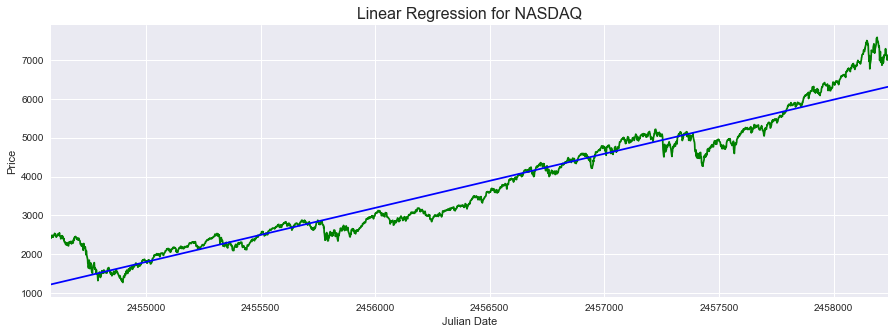

In [15]:
from sklearn import linear_model

# instantiate our model.
regr = linear_model.LinearRegression()

x = nas_df['Julian'].to_frame()     # Date
y = nas_df['Close']                 # Closing Price      

# fit the model
regr.fit(x,y)

# display the attributes
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R^2 Value: \n', regr.score(x, y))

# plot the outputs
plt.figure(figsize = (15,5))

plt.plot(x, y, color = 'green')
plt.plot(x, regr.predict(x), color = 'blue')
plt.title('Linear Regression for NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([nas_df.Julian[-1], nas_df.Julian[0]])

plt.savefig('benchmark')
plt.show()

$$Equation: y = \alpha x + \beta $$

In [16]:
# set intercept and slope for the equation
inter = regr.intercept_
slope = regr.coef_

# predict the results of current day
result = slope * (x['Julian'][0]) + inter
print('Predicted Closing Price of Next Day: {0:.2f}'.format(result[0]))

Predicted Closing Price of Next Day: 6312.03


    Looks like it is a good start. Linear Regression is able to accurately show the trend of the market. The blue line (predicted line) seems to closely represent the green line (original market index). The predicted close price of the current day is $6313.42 and the true value is $7128.60. The different is roughly $800, but this is a benchmark, the model will be improved.

# Prediction with SVR

In [115]:
# training and test set for the model
testsize = int(nas_df.shape[0] * 0.2)
nas_df_test, nas_df_train = nas_df[:testsize], nas_df[testsize:]

In [116]:
from sklearn.svm import SVR

x_train = nas_df_train.Julian.to_frame()     # Julian Dates
y_train = nas_df_train.Close                 # Closing Prices

# initialize SVM for rbf 
svr_rbf = SVR(kernel = 'rbf', C = 500, gamma = 0.005)

# fit the model
svr_rbf.fit(x_train, y_train)

# calculate the R^2 of the training set
print('Training Set:', svr_rbf.score(x_train, y_train))

# validate with test set
x_test = nas_df_test.Julian.to_frame()     # Julian Dates
y_test = nas_df_test.Close                 # Closing Prices

# calculate the R^2 of the test set
print('Test Set:', svr_rbf.score(x_test, y_test))

Training Set: 0.999016777284
Test Set: -12.7349124726


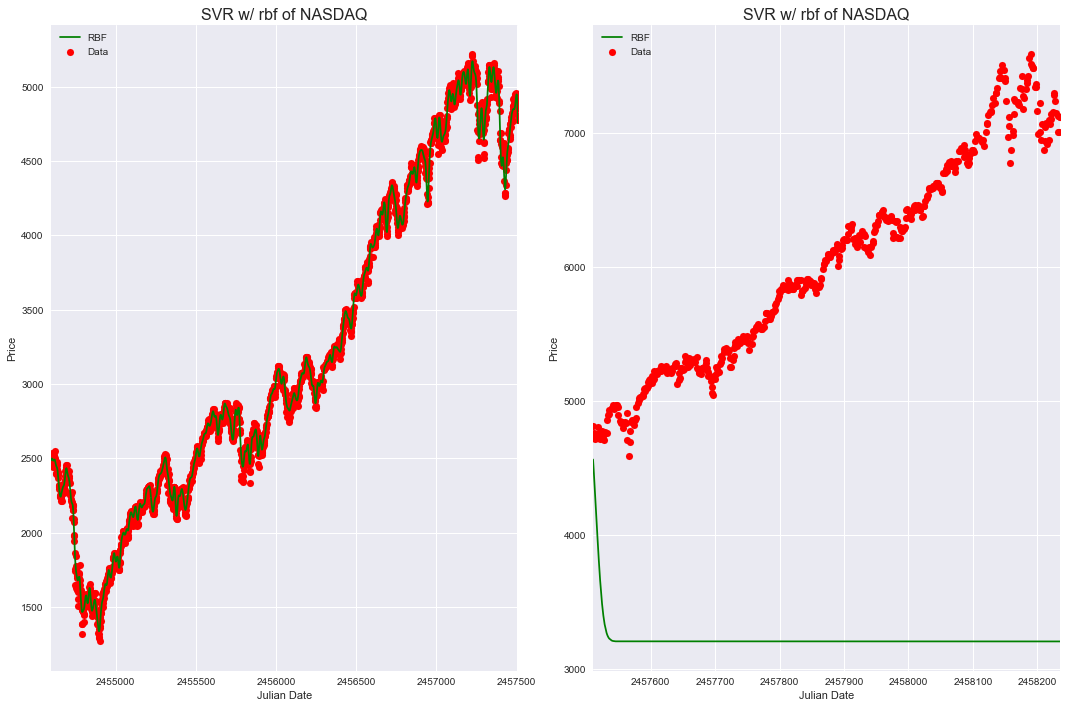

In [118]:
# plot the graph
plt.figure(figsize = (15,10))

plt.subplot(121)
plt.scatter(x_train, y_train, color = 'red', label = 'Data', linewidths = 0.1)
plt.plot(x_train, svr_rbf.predict(x_train), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([nas_df_train.Julian[-1], nas_df_train.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.subplot(122)
plt.scatter(x_test, y_test, color = 'red', label = 'Data', linewidths = 0.1)
plt.plot(x_test, svr_rbf.predict(x_test), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([nas_df_test.Julian[-1], nas_df_test.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.tight_layout()
plt.savefig('SVM_1')
plt.show()

    Does not look good, with negative R^2 for the test set and a high R^2 for the training set. It seems like this model is overfitting, that it cannot be used to predict any other dataset. Hence the negative R^2, it means that the prediction is inaccurate. From the graphs, we can see in the training set that the predicted line (green) closely represents the original values however towards the end there is a huge drop. And then in the test set, the predicted line and original graph do not intercept at any point.

##### Manually calculate the R^2
    The coefficient R^2 is defined as (1 - u/v): 
* u is the residual sum of squares ((y_true - y_pred) ** 2).sum()
* v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()

    The purpose is to see the differences between the predicted values and original values. I want to see how big the error is.

In [119]:
comp_train = pd.DataFrame({'original': y_train,
                     'predicted': svr_rbf.predict(x_train)})

comp_train['abs_%_error'] = abs((comp_train.original - comp_train.predicted) / comp_train.original)
comp_train.head()

,original,predicted,abs_%_error
Date,,,
2016-04-29,4775.359863,4755.974016,0.004060
2016-04-28,4805.290039,4805.190515,0.000021
2016-04-27,4863.140137,4846.634024,0.003394
2016-04-26,4888.279785,4880.359985,0.001620
2016-04-25,4895.790039,4906.627056,0.002214


In [120]:
comp_test = pd.DataFrame({'original': y_test,
                          'predicted': svr_rbf.predict(x_test)})
comp_test['abs_%_error'] = abs((comp_test.original - comp_test.predicted) / comp_test.original)
comp_test.head()

,original,predicted,abs_%_error
Date,,,
2018-04-27,7119.799805,3207.822083,0.549451
2018-04-26,7118.680176,3207.822083,0.549380
2018-04-25,7003.740234,3207.822083,0.541984
2018-04-24,7007.350098,3207.822083,0.542220
2018-04-23,7128.600098,3207.822083,0.550007


In [138]:
# training set
u = ((comp_train.original - comp_train.predicted) ** 2).sum()
v = ((comp_train.original - comp_train.original.mean()) ** 2).sum()

print('Training Set')
print('u = {0:.2f} \nv = {1:.2f}\n'.format(u, v))
print('Original Mean: {0:.2f}'.format(comp_train.original.mean()))
print('Predicted Mean:{0:.2f}'.format(comp_train.predicted.mean()))
print('\nR^2: {0:.2f}'.format(1 - u/v))

Training Set
u = 2326699.33 
v = 2366401109.22

Original Mean: 3204.98
Predicted Mean:3205.72

R^2: 1.00


In [137]:
# test set
u = ((comp_test.original - comp_test.predicted) ** 2).sum()
v = ((comp_test.original - comp_test.original.mean()) ** 2).sum()

print('Test Set')
print('u = {0:.2f} \nv = {1:.2f}\n'.format(u, v))
print('Original Mean: {0:.2f}'.format(comp_test.original.mean()))
print('Predicted Mean:{0:.2f}'.format(comp_test.predicted.mean()))
print('\nR^2: {0:.2f}'.format(1 - u/v))

Test Set
u = 4257208353.25 
v = 309955259.03

Original Mean: 6019.86
Predicted Mean:3228.17

R^2: -12.73


    As we can see from the results, in the training set, the original mean and predicted mean are almost identical. Whereas in the test set, the original mean is 7212.16 and the predicted is 3821.43, which is almost half of the original. 

# A more complex SVR model
### w/ more features to improve model
* Moving Average ( 3 day, 5 day )  - start with one, use mean, median
* High-Low Price

In [123]:
# calculate the Moving Average of 5 days for NASDAQ Closing Price
mov_avg = nas_df.Close.rolling(window = 5).mean().shift(-4)   # the moving average is corresponding to the n previous day

# create a column for moving average
nas_df['MA_5'] = mov_avg

# Potential Features 
# create a feature called 'Mid' 
# which is the middle between 'High' and 'Low'
nas_df['Mid'] = (nas_df.High + nas_df.Low) / 2

# determine if the closing price is above or below 'Mid' price of the day
# if the closing price is above the mid-point, shows a sign of growth ==> 1
# and if the closing is below the mid-point, shows a sign of decline ==> 0 

nas_df['Diff'] = nas_df.Close - nas_df.Mid
nas_df['Sign'] = nas_df.Diff.apply(lambda x: 1 if x >= 0 else 0)

# drop null values
nas_df.dropna(inplace = True)

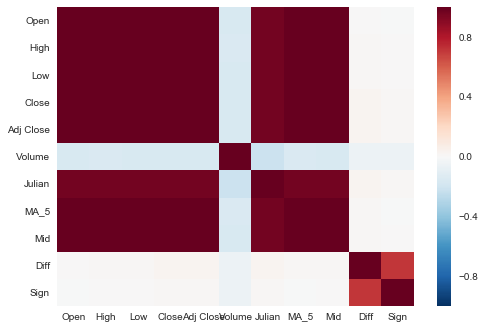

In [124]:
# use heatmap to show correlations of features
nas_df_corr = nas_df.corr()
sns.heatmap(nas_df_corr)

plt.savefig('SVM_heatmap')
plt.show()

    After creating the new features, but it looks like they are closely correlated with each other. It is a bad sign, because when new features are closely correlated with the old features, the new features do not offer any useful information to the model, hence will not have a positive impact. 

In [125]:
# training and test set for the model
testsize = int(nas_df.shape[0] * 0.2)
nas_df_test, nas_df_train = nas_df[:testsize], nas_df[testsize:]

In [126]:
x_train = nas_df_train.loc[:, ~nas_df_train.columns.isin(['Close'])]  
y_train = nas_df_train.Close                    # Closing Prices

# initialize SVM for rbf
svr_rbf = SVR(kernel = 'rbf', C = 2000, gamma = 0.05)

# fit the model
svr_rbf.fit(x_train, y_train)

# calculate the R^2 
print('Training Set: ', svr_rbf.score(x_train, y_train))

# validate with test set
x_test = nas_df_test.loc[:, ~nas_df_test.columns.isin(['Close'])]   
y_test = nas_df_test.Close                    # Closing Prices

# calculate the test set
print('Test Set: ', svr_rbf.score(x_test, y_test))

Training Set:  0.999999930868
Test Set:  -12.8685084779


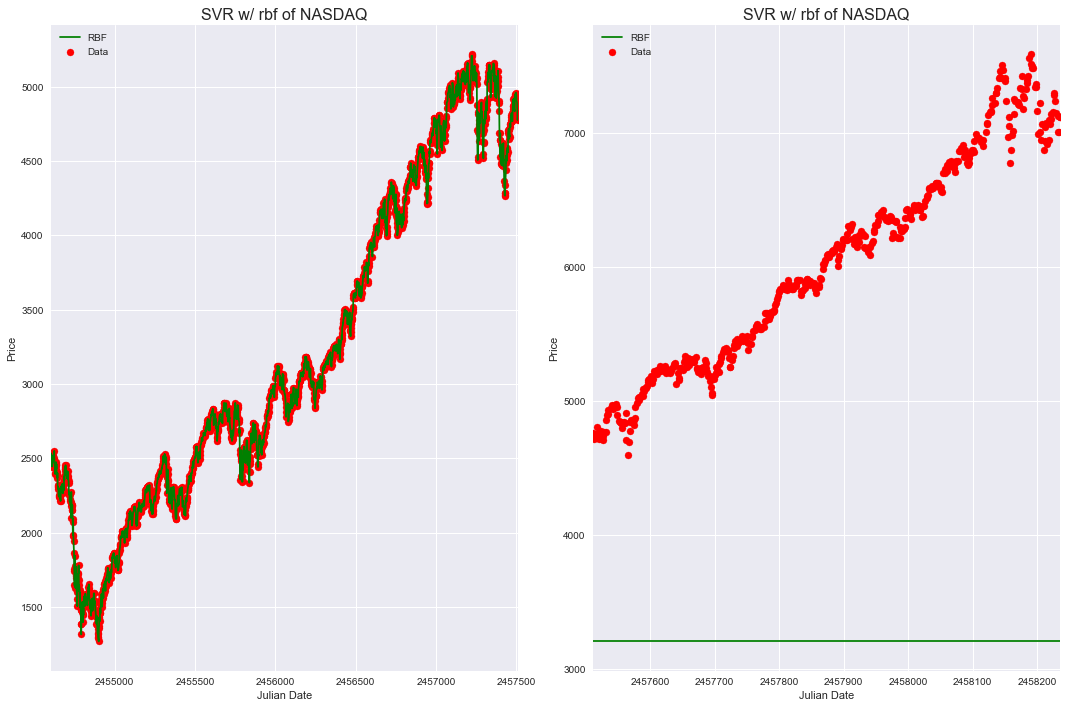

In [127]:
plt.figure(figsize = (15,10))

plt.subplot(121)
plt.scatter(x_train.Julian, y_train, color = 'red', label = 'Data')
plt.plot(x_train.Julian, svr_rbf.predict(x_train), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_train.Julian[-1], x_train.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.subplot(122)
plt.scatter(x_test.Julian, y_test, color = 'red', label = 'Data')
plt.plot(x_test.Julian, svr_rbf.predict(x_test), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_test.Julian[-1], x_test.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.tight_layout()
plt.savefig('SVM_2')
plt.show()

    According to the heatmap and the new results, it doesn't see like add too many features are useful. There are too many unnecessary feature.

# Removing all unnecessary features
### Re-try SVM model

In [128]:
x_train = nas_df_train[['Volume', 'MA_5', 'Julian']]
y_train = nas_df_train.Close                    # Closing Prices

# initialize SVM for 3 regressions: linear, poly, rbf
svr_rbf = SVR(kernel = 'rbf', C = 2000, gamma = 0.05)

# fit the model
svr_rbf.fit(x_train, y_train)

# calculate the R^2 
print('Training Set: ', svr_rbf.score(x_train, y_train))

# validate with test set
x_test = nas_df_test[['Volume', 'MA_5', 'Julian']]
y_test = nas_df_test.Close                    # Closing Prices

# calculate the test set
print('Test Set: ', svr_rbf.score(x_test, y_test))

Training Set:  0.999999930847
Test Set:  -12.8685084779


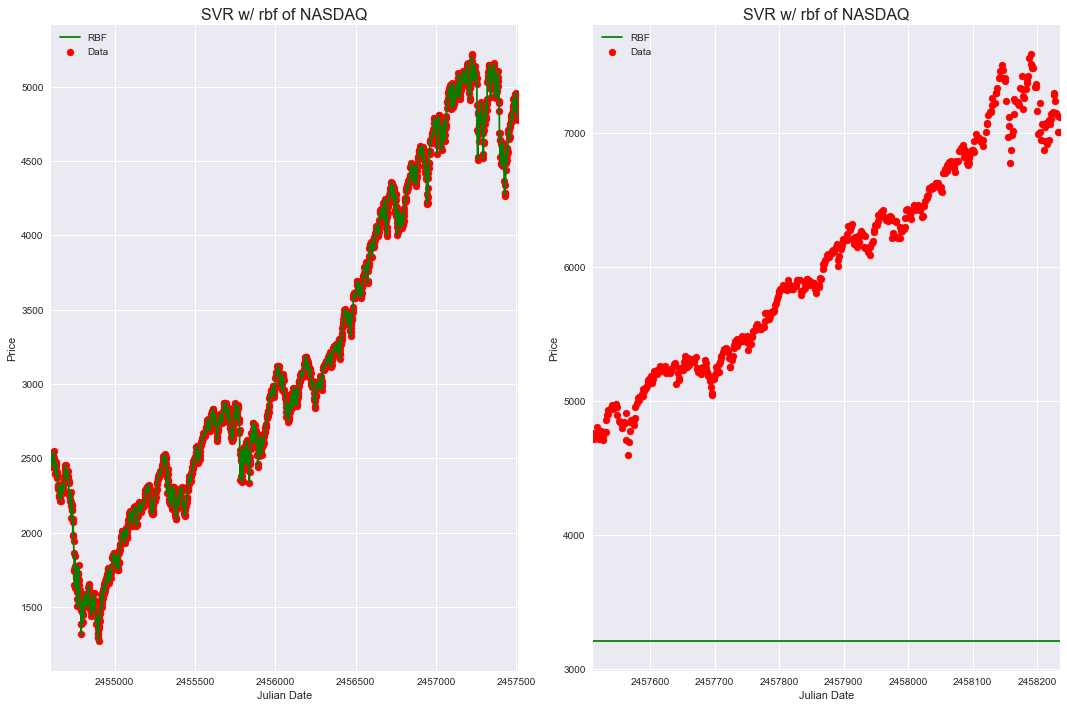

In [129]:
plt.figure(figsize = (15,10))

plt.subplot(121)
plt.scatter(x_train.Julian, y_train, color = 'red', label = 'Data')
plt.plot(x_train.Julian, svr_rbf.predict(x_train), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_train.Julian[-1], x_train.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.subplot(122)
plt.scatter(x_test.Julian, y_test, color = 'red', label = 'Data')
plt.plot(x_test.Julian, svr_rbf.predict(x_test), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_test.Julian[-1], x_test.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.tight_layout()
plt.savefig('SVM_3')
plt.show()

    Did not improve at all.

### Try PCA w/ SVM

In [130]:
from sklearn.decomposition import PCA 
nas_pca = nas_df.copy()

y_pca = nas_pca['Close']
x_pca = nas_pca.loc[:, ~nas_pca.columns.isin(['Close'])]

sklearn_pca = PCA(n_components = 1)
x_pca = sklearn_pca.fit_transform(x_pca)
x_pca = pd.DataFrame(x_pca)     # transform x_pca (meta features) into dataframe

# create a training set and test set sizes
testsize = int(nas_pca.shape[0] * 0.2)
x_pca_train, y_pca_train = x_pca[testsize:], y_pca[testsize:]
x_pca_test, y_pca_test = x_pca[:testsize], y_pca[:testsize]

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

print(
    '\nThe sum of variances in the dataset explained. \n',
    sum(sklearn_pca.explained_variance_ratio_)
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 1.]

The sum of variances in the dataset explained. 
 0.999999999913


    From the looks of PCA, it looks like only one feature is needed

In [131]:
# initialize SVM rbf using PCA
pca_svr_rbf = SVR(kernel = 'rbf', C = 1500, gamma = 0.01)

# pca training set 
pca_svr_rbf.fit(x_pca_train, y_pca_train)
print('Training Set:', pca_svr_rbf.score(x_pca_train, y_pca_train))

# pca test set 
print('Test Set:', pca_svr_rbf.score(x_pca_test, y_pca_test))

Training Set: 0.97794079917
Test Set: -13.1175076357


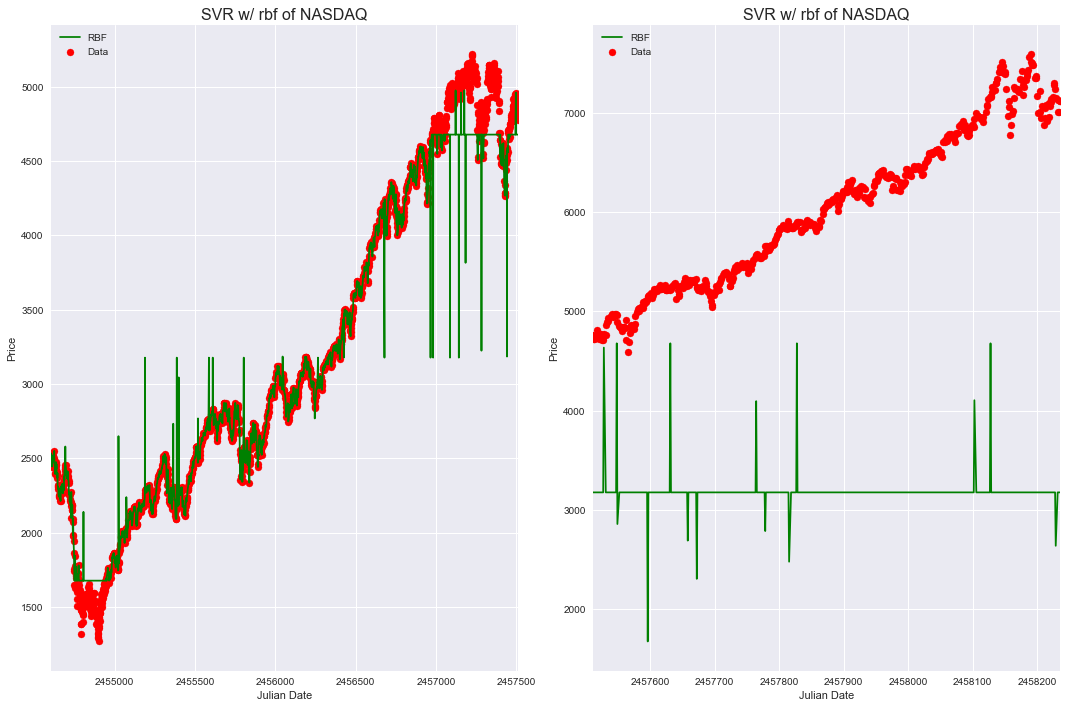

In [133]:
plt.figure(figsize = (15,10))

plt.subplot(121)
plt.scatter(x_train.Julian, y_pca_train, color = 'red', label = 'Data')
plt.plot(x_train.Julian, pca_svr_rbf.predict(x_pca_train), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_train.Julian[-1], x_train.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.subplot(122)
plt.scatter(x_test.Julian, y_pca_test, color = 'red', label = 'Data')
plt.plot(x_test.Julian, pca_svr_rbf.predict(x_pca_test), color = 'green', label = 'RBF')
plt.title('SVR w/ rbf of NASDAQ', fontsize = 16)
plt.xlabel('Julian Date')
plt.ylabel('Price')
plt.xlim([x_test.Julian[-1], x_test.Julian[0]])
plt.legend(['RBF', 'Data'])

plt.tight_layout()
plt.savefig('SVM_4')
plt.show()

    Although there is an improvment to the model after using PCA, but the R^2 is still in the negative. After attempting both Supervised and Unsupervised techniques, they both do not seem to work very well. This result is mostly likely due to my lack of knowledge for unable to create better features for modeling. I do believe that Support Vector Machine could work for stock market prediction.
    
    Note to Self: Come back later after learning more to improve SVM for stock market prediction.

# ARIMA Model

    Since both supervised and unsupervised techniques do not work for me. I plan to use the new model: ARIMA

In [38]:
# make a copy of the original NASDAQ dataset
nas_arima = nas.copy()
nas_arima.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-04-28,2422.629883,2437.000000,2416.899902,2424.399902,2424.399902,1724680000
2008-04-29,2420.000000,2435.379883,2412.100098,2426.100098,2426.100098,1769030000
2008-04-30,2434.199951,2451.189941,2406.370117,2412.800049,2412.800049,2127390000
2008-05-01,2416.489990,2480.709961,2416.489990,2480.709961,2480.709961,2344770000
2008-05-02,2499.139893,2499.139893,2461.459961,2476.989990,2476.989990,2279510000


In [39]:
# drop all the unnecessary features
nas_arima.drop(['Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True)

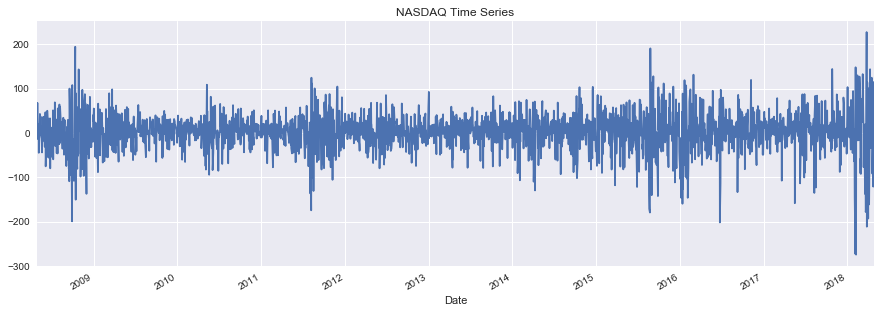

In [40]:
# set graph size
plt.figure(figsize = (15,5))

# plot the differences to show stationarity
nas_arima['Diff'] = nas_arima.Close - nas_arima.Close.shift()
nas_arima.dropna(inplace = True)

nas_arima.Diff.plot(y = 'Diff')
plt.title('NASDAQ Time Series')

plt.savefig('stationary_1')
plt.show()

C:\Users\Mike\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


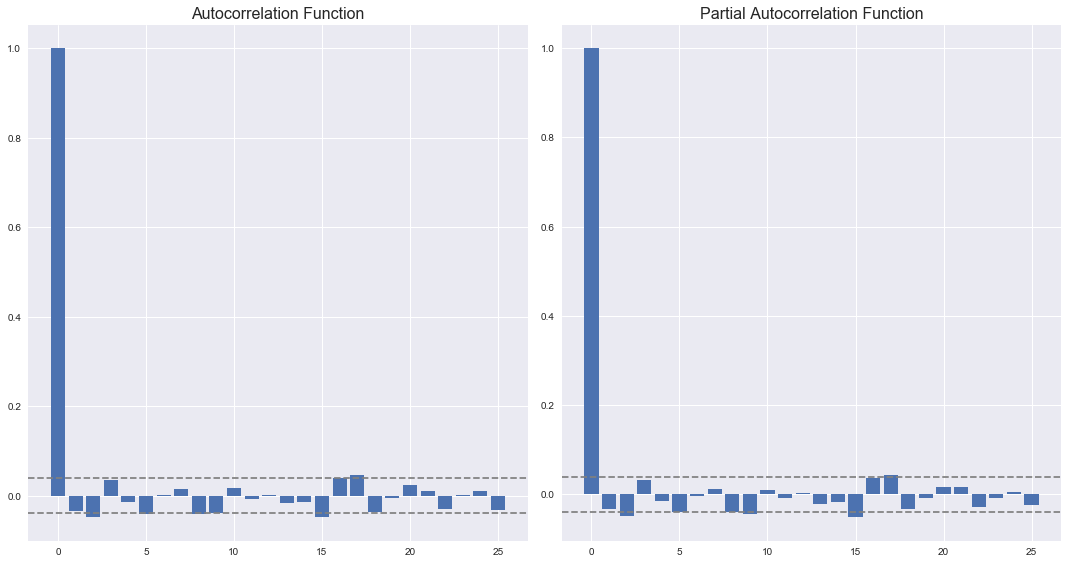

In [41]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(nas_arima.Diff, nlags = 25)
lag_pacf = pacf(nas_arima.Diff, nlags = 25, method='ols')

# set graph size
plt.figure(figsize = (15,8))

# plot ACF
plt.subplot(121)
plt.bar(range(len(lag_acf)), lag_acf)
plt.axhline(y = -1.96/np.sqrt(len(nas_arima.Diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(nas_arima.Diff)), linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize = 16)

# plot PACF
plt.subplot(122)
plt.bar(range(len(lag_pacf)), lag_pacf)
plt.axhline(y = -1.96/np.sqrt(len(nas_arima.Diff)), linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(nas_arima.Diff)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize = 16)

plt.tight_layout()
plt.savefig('autocorrelation_1')
plt.show()

$$\alpha  = 0.5$$
* give an explanation to 1.96 => cdf(0.975) 

    How to choose value of p and q in the arima model:
    
* p is based on number of time bar graph cross the upper confidence interval in pacf
* q is based on number of time bar graph cross the upper confidence interval in acf

In [42]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(nas_arima.Close, order = (1,1,0))
model_fit = model.fit()

print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2517
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12980.255
Method:                       css-mle   S.D. of innovations             42.018
Date:                Mon, 07 May 2018   AIC                          25966.509
Time:                        09:30:58   BIC                          25984.002
Sample:                    04-30-2008   HQIC                         25972.858
                         - 04-27-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8650      0.810      2.302      0.021       0.277       3.453
ar.L1.D.Close    -0.0340      0.020     -1.705      0.088      -0.073       0.005
                                    Root

After changing p and q values:   
*    want p-value < 0.05
*    confidence interval to not include 0
*    no imaginary number
*    minimal AIC

In [43]:
# want test set to be only in 2018
size = len(nas_arima['2018'])

# create training and test set
arima_test, arima_train = nas_arima[-size:], nas_arima[:-size]
train_set = [x for x in arima_train.Close]
prediction = list()

for t in range(len(arima_test)):
    model = ARIMA(train_set, order = (1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat[0])
    obs = arima_test.Close[t]
    train_set.append(obs)

res = pd.DataFrame({'predicted': prediction,
                    'actual': nas_arima.Close[-size:]})
res.head()

,actual,predicted
Date,,
2018-01-02,7006.899902,6906.763582
2018-01-03,7065.529785,7005.436156
2018-01-04,7077.910156,7065.660093
2018-01-05,7136.560059,7079.492290
2018-01-08,7157.390137,7136.737856


Test MSE: 9304.464


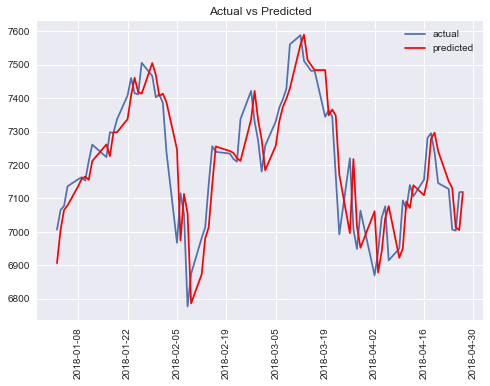

In [141]:
# Mean Square Error

from sklearn.metrics  import mean_squared_error
ms_error = mean_squared_error(res.actual, res.predicted)
print('Test MSE: {0:.3f}'.format(ms_error))

# plot
plt.plot(res.actual)
plt.plot(res.predicted, color='red')
plt.title('Actual vs Predicted')
plt.xticks(rotation = 90)
plt.legend()
plt.savefig('mse_1')
plt.show()

In [45]:
# Mean Absolute Proportional Error

def mape(actual, predicted):
    
    proportional_error = ((actual - predicted) / actual ) * 100
    mape = abs(proportional_error).sum() / len(proportional_error)
    
    return mape;

In [46]:
# MAPE for ARIMA Model
mape_result = mape(res.actual, res.predicted)
print('Mean Absolute Proportional Error: {0:.3f}'.format(mape_result))

Mean Absolute Proportional Error: 1.028


In [47]:
# Mean Absolute Scaled Error

def mase(training, actual, predicted):
    train_mse = abs(np.diff(training)).sum() / (len(training) - 1)
    test_error = abs(actual - predicted)
    mase = test_error.mean() / train_mse
    
    return mase;

In [48]:
# MASE for ARIMA Model
mase_result = mase(arima_train.Close, res.actual, res.predicted)
print('Mean Absolute Scaled Error: {0:.3f}'.format(mase_result))

Mean Absolute Scaled Error: 2.611


In [49]:
output_arima = model_fit.forecast(steps = 30, alpha = 0.01)
output_arima[0]

array([ 7116.69584549,  7118.69059486,  7120.54993114,  7122.41387569,
        7124.27766342,  7126.14145649,  7128.00524938,  7129.86904227,
        7131.73283516,  7133.59662806,  7135.46042095,  7137.32421384,
        7139.18800673,  7141.05179963,  7142.91559252,  7144.77938541,
        7146.6431783 ,  7148.5069712 ,  7150.37076409,  7152.23455698,
        7154.09834987,  7155.96214276,  7157.82593566,  7159.68972855,
        7161.55352144,  7163.41731433,  7165.28110723,  7167.14490012,
        7169.00869301,  7170.8724859 ])

    this is to be expected since for the last 10 years the trend has been a constant rise. Need a larger timeframe.

# with log transformation

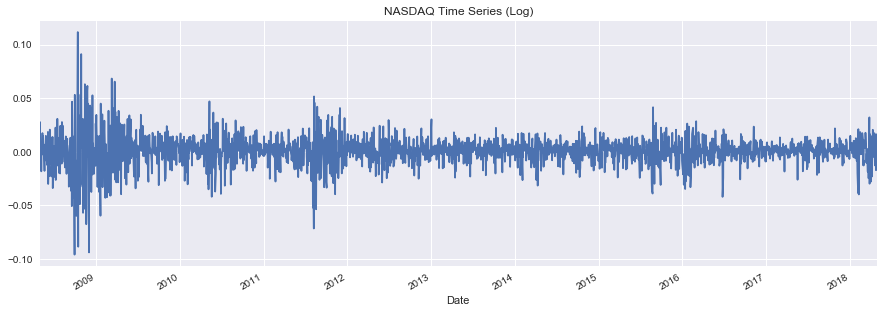

In [50]:
nas_arima_log = np.log(nas_arima.Close)

nas_arima_log_diff = nas_arima_log - nas_arima_log.shift()
nas_arima_log_diff.dropna(inplace = True)

plt.figure(figsize=(15,5))
nas_arima_log_diff.plot( y = 'log_diff')
plt.title('NASDAQ Time Series (Log)')
plt.savefig('stationary_2')
plt.show()

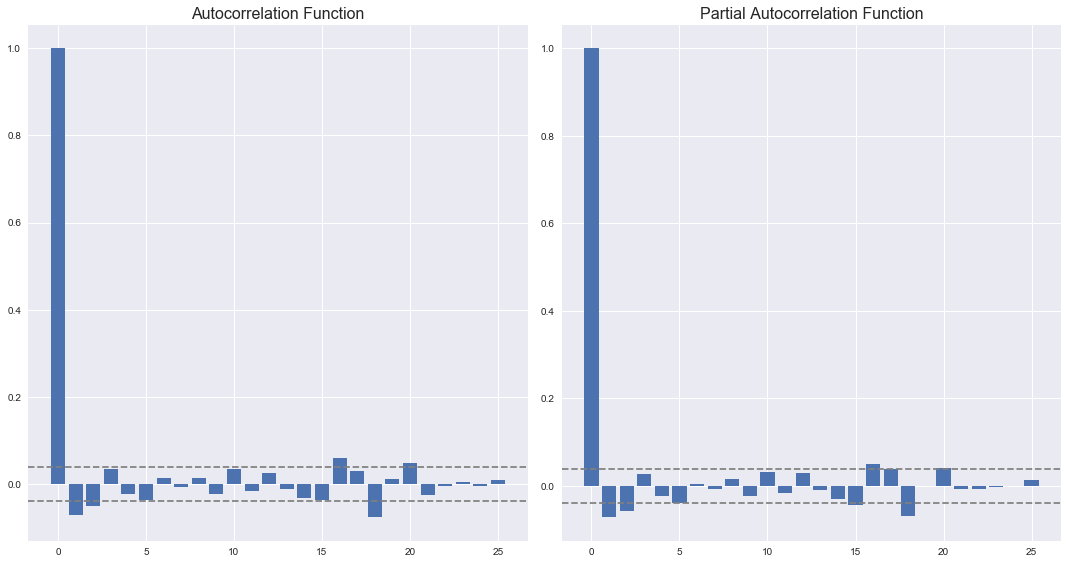

In [51]:
log_lag_acf = acf(nas_arima_log_diff, nlags = 25)
log_lag_pacf = pacf(nas_arima_log_diff, nlags = 25, method='ols')

# set graph size
plt.figure(figsize = (15,8))

# plot ACF
plt.subplot(121)
plt.bar(range(len(log_lag_acf)), log_lag_acf)
plt.axhline(y = -1.96/np.sqrt(len(nas_arima_log_diff)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(nas_arima_log_diff)), linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize = 16)

# plot PACF
plt.subplot(122)
plt.bar(range(len(log_lag_pacf)), log_lag_pacf)
plt.axhline(y = -1.96/np.sqrt(len(nas_arima_log_diff)), linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(nas_arima_log_diff)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize = 16)

plt.tight_layout()
plt.savefig('autocorrelation_2')
plt.show()

In [52]:
model_log = ARIMA(nas_arima_log, order = (1,1,1))
model_log_fit = model_log.fit()

print(model_log_fit.summary())
print('Residuals Description')
print(model_log_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2517
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7252.678
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 07 May 2018   AIC                         -14497.355
Time:                        09:31:02   BIC                         -14474.032
Sample:                    04-30-2008   HQIC                        -14488.891
                         - 04-27-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.822      0.069   -3.24e-05       0.001
ar.L1.D.Close     0.4106      0.203      2.019      0.044       0.012       0.809
ma.L1.D.Close    -0.4888      0.195     

In [53]:
# create training and test set
arima_log_test, arima_log_train = nas_arima_log[-size:], nas_arima_log[:-size]
train_log_set = [x for x in arima_log_train]
log_prediction = list()

for t in range(len(arima_log_test)):
    model_log = ARIMA(train_log_set, order = (1,1,1))
    model_log_fit = model_log.fit()
    output = model_log_fit.forecast()
    yhat = output[0]
    log_prediction.append(yhat[0])
    obs = arima_log_test[t]
    train_log_set.append(obs)

log_res = pd.DataFrame({'predicted': log_prediction,
                        'actual': arima_log_test})
log_res.tail()    

C:\Users\Mike\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,actual,predicted
Date,,
2018-04-23,8.871870,8.875905
2018-04-24,8.854715,8.873081
2018-04-25,8.854200,8.856888
2018-04-26,8.870478,8.855538
2018-04-27,8.870635,8.870120


Test MSE: 0.000


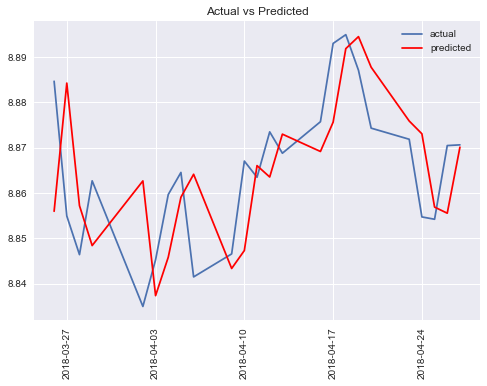

In [142]:
error = mean_squared_error(log_res.actual[-size:], log_res.predicted[-size:])
print('Test MSE: {0:.3f}'.format(error))

# plot
plt.plot(log_res.actual[-size:])
plt.plot(log_res.predicted[-size:], color='red')
plt.title('Actual vs Predicted')
plt.xticks(rotation = 90)
plt.legend()
plt.savefig('mse_2')
plt.show()

In [55]:
log_mape = mape(log_res.actual, log_res.predicted)
print('Log MAPE: {0:.3f}'.format(log_mape))

Log MAPE: 0.115


In [56]:
log_mase = mase(arima_log_train, log_res.actual, log_res.predicted)
print('Log MASE: {0:.3f}'.format(log_mase))

Log MASE: 1.139


In [57]:
log_output = model_log_fit.forecast(steps = 30, alpha = 0.01)
log_output[0]

array([ 8.87012004,  8.87022508,  8.87051995,  8.87089271,  8.87129744,
        8.87171528,  8.87213851,  8.87256394,  8.87299028,  8.87341699,
        8.87384385,  8.87427078,  8.87469773,  8.87512469,  8.87555166,
        8.87597863,  8.8764056 ,  8.87683257,  8.87725954,  8.87768651,
        8.87811348,  8.87854045,  8.87896742,  8.87939439,  8.87982136,
        8.88024833,  8.8806753 ,  8.88110227,  8.88152924,  8.88195621])

    Conclusion:
    It seems like ARIMA models have a much accurate prediction
    #need more

# Inflation using CPI

##### Data:
https://fred.stlouisfed.org/graph/?g=wic

In [58]:
# parse date
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# import CPI monthly
cpi_monthly = pd.read_csv('Monthly.csv', parse_dates = ['DATE'], index_col = 'DATE', date_parser = dateparse)
cpi_quarterly = pd.read_csv('Quarterly.csv', parse_dates = ['DATE'], index_col = 'DATE', date_parser = dateparse)

In [59]:
print('CPI Monthly:\n')
print(cpi_monthly.dtypes)
print('\n Dimension:', cpi_monthly.shape)
print('********************************')
print('CPI Quarterly:\n')
print(cpi_quarterly.dtypes)
print('\n Dimension:', cpi_quarterly.shape)

CPI Monthly:

CPIAUCSL    float64
CPILFESL    float64
PCEPI       float64
dtype: object

 Dimension: (121, 3)
********************************
CPI Quarterly:

GDPDEF    float64
dtype: object

 Dimension: (41, 1)


######   CPI Monthly 
* CPIAUCSL - Consumer Price Index for All Urban Consumers 
* CPILFESL - Consumer Price Index for All Urban Consumers: All Items Less Food and Energy (exclude food and energy)
* PCEPI - Personal Consumption Expenditures

In [60]:
cpi_monthly = cpi_monthly.sort_index(ascending = False)
cpi_monthly.dropna(inplace = True)
cpi_monthly.head()

,CPIAUCSL,CPILFESL,PCEPI
DATE,,,
2018-01-01,249.245,255.287,114.082
2017-12-01,247.910,254.398,113.644
2017-11-01,247.411,253.791,113.483
2017-10-01,246.583,253.484,113.250
2017-09-01,246.392,252.943,113.077


##### CPI Quarterly
* GDPDEF - Gross Domestic Product: Implicit Price Deflatord

In [61]:
cpi_quarterly = cpi_quarterly.sort_index(ascending = False)
cpi_quarterly.dropna(inplace = True)
cpi_quarterly.head()

,GDPDEF
DATE,
2018-01-01,114.837
2017-10-01,114.275
2017-07-01,113.614
2017-04-01,113.029
2017-01-01,112.746


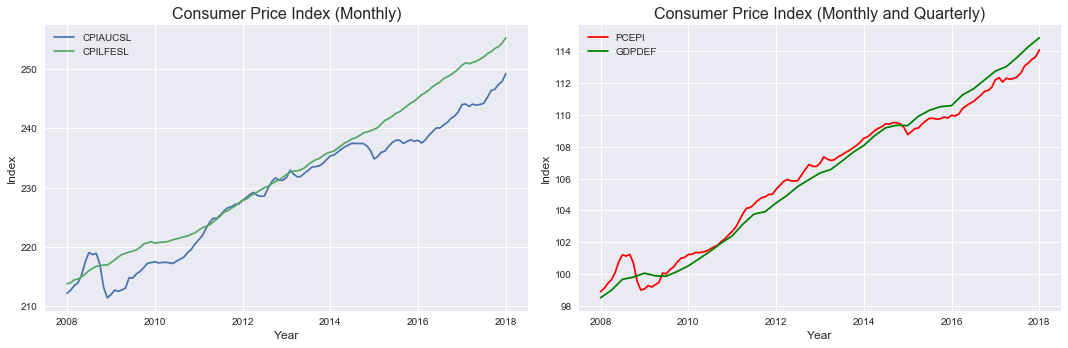

In [62]:
# set graph size
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(cpi_monthly['CPIAUCSL'])
plt.plot(cpi_monthly['CPILFESL'])
plt.title('Consumer Price Index (Monthly)', fontsize = 16)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Index', fontsize = 12)
plt.legend()

plt.subplot(122)
plt.plot(cpi_monthly['PCEPI'], color = 'red')
plt.plot(cpi_quarterly['GDPDEF'], color = 'green')
plt.title('Consumer Price Index (Monthly and Quarterly)', fontsize = 16)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Index', fontsize = 12)
plt.legend()

plt.tight_layout()
plt.savefig('cpi_comparison')
plt.show()

    provide explanation to the graph
    want to choose only the CPI (left 2 lines)
    prices seem to be constantly inflating

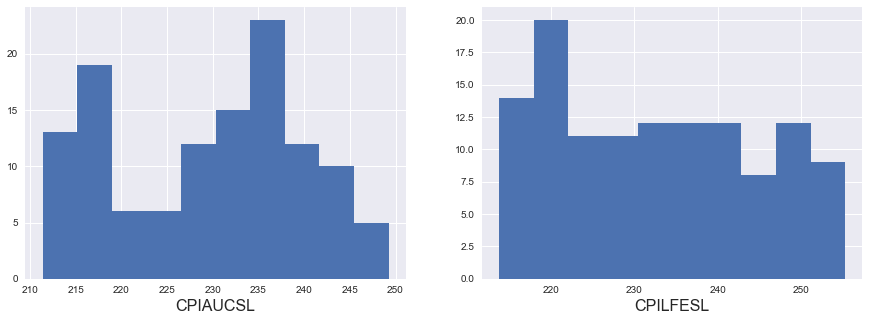

In [63]:
# Hist for CPIAUCSL
plt.figure(figsize=(15,5))
plt.subplot(121)
cpi_monthly.CPIAUCSL.hist()
plt.xlabel('CPIAUCSL', fontsize = 16)

plt.subplot(122)
cpi_monthly.CPILFESL.hist()
plt.xlabel('CPILFESL', fontsize = 16)

plt.savefig('cpi_hist')
plt.show()

    no outliers

# work on CPI w/CPIAUCSL (CPI 1)

In [64]:
# choose the a CPI to work with
cpi1 = cpi_monthly['CPIAUCSL'].copy()

# reverse the order of the dates
# start with index [0]  => 2018
# and end with => 2008
cpi1 = cpi1.sort_index(ascending = True)
cpi1.head()

DATE
2008-01-01    212.174
2008-02-01    212.687
2008-03-01    213.448
2008-04-01    213.942
2008-05-01    215.208
Name: CPIAUCSL, dtype: float64

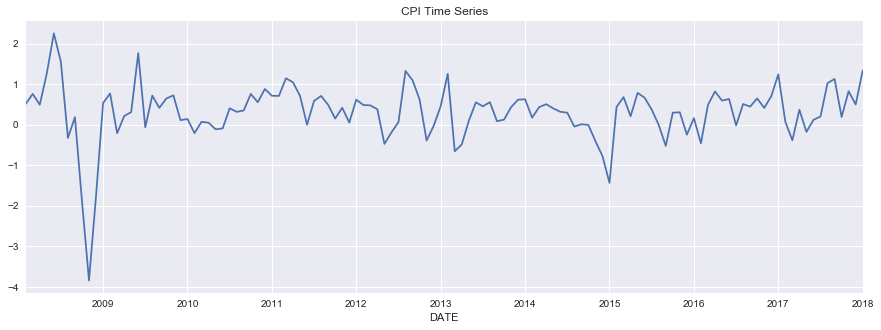

In [65]:
# stationary graph for CPIAUCSL
# set graph size
plt.figure(figsize = (15,5))

# plot the differences to show stationarity
diff_1 = (cpi1 - cpi1.shift()).dropna()
diff_1.plot()
plt.title('CPI Time Series')
plt.savefig('cpi_stationary_1')
plt.show()

    there is a sharp drop around 2008, but it is to be expected because of the recession that happened in 2008

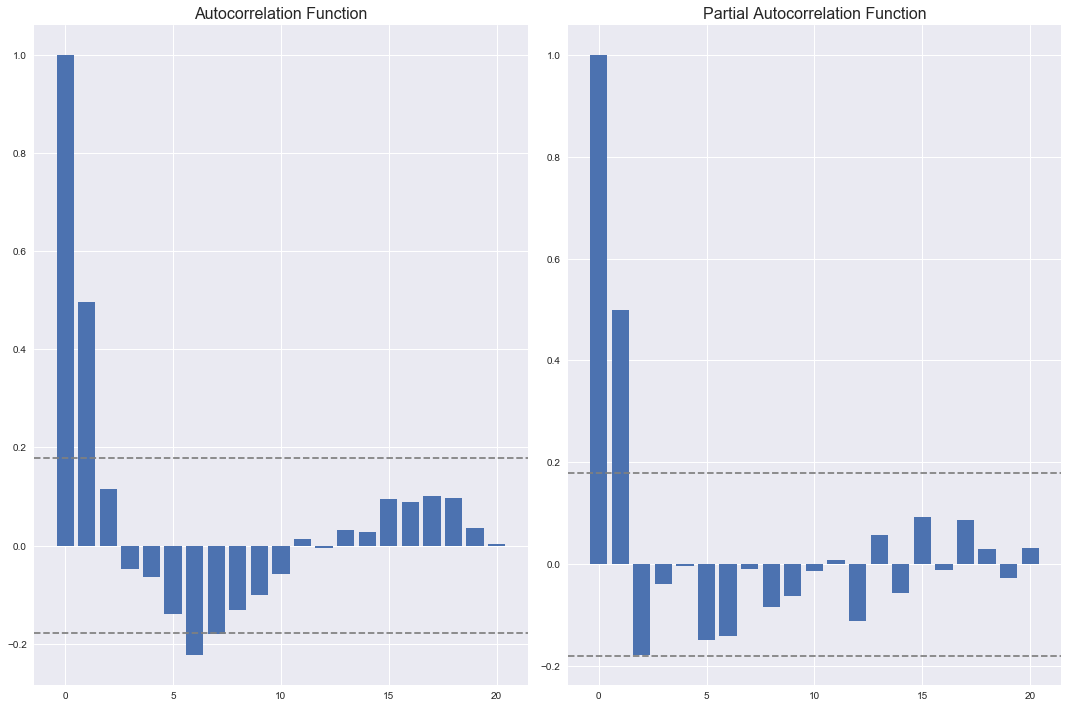

In [66]:
cpi1_lag_acf = acf(diff_1, nlags = 20)
cpi1_lag_pacf = pacf(diff_1, nlags = 20)

# set graph size
plt.figure(figsize = (15,10))

# plot ACF
plt.subplot(121)
plt.bar(range(len(cpi1_lag_acf)), cpi1_lag_acf)
plt.axhline(y = -1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(diff_1)), linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize = 16)

# plot PACF
plt.subplot(122)
plt.bar(range(len(cpi1_lag_pacf)), cpi1_lag_pacf)
plt.axhline(y = -1.96/np.sqrt(len(diff_1)), linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(diff_1)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize = 16)

plt.tight_layout()
plt.savefig('cpi_autocorr_1')
plt.show()

In [67]:
model_cpi1 = ARIMA(cpi1, order = (1,1,0))
model_cpi1_fit = model_cpi1.fit()

print(model_cpi1_fit.summary())
print('Residuals Description')
print(model_cpi1_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:             D.CPIAUCSL   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -110.617
Method:                       css-mle   S.D. of innovations              0.608
Date:                Mon, 07 May 2018   AIC                            227.233
Time:                        09:31:21   BIC                            235.596
Sample:                    02-01-2008   HQIC                           230.629
                         - 01-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3190      0.110      2.896      0.005       0.103       0.535
ar.L1.D.CPIAUCSL     0.5006      0.079      6.316      0.000       0.345       0.656
                            

In [68]:
# create training and test set
size = int(cpi1.shape[0] * 0.2)
cpi1_test, cpi1_train = cpi1[-size:], cpi1[:-size]
cpi1_train_set = [x for x in cpi1_train]
cpi1_prediction = list()

for t in range(len(cpi1_test)):
    model_cp1 = ARIMA(cpi1_train_set, order = (1,1,0))
    model_cp1_fit = model_cp1.fit()
    output = model_cp1_fit.forecast()
    yhat = output[0]
    cpi1_prediction.append(yhat[0])
    obs = cpi1_test[t]
    cpi1_train_set.append(obs)

cpi1_res = pd.DataFrame({'predicted': cpi1_prediction,
                         'actual': cpi1_test})
cpi1_res.head()

,actual,predicted
DATE,,
2016-02-01,237.532,238.204699
2016-03-01,238.022,237.416826
2016-04-01,238.843,238.404050
2016-05-01,239.439,239.399942
2016-06-01,240.074,239.880827


Test MSE: 0.242


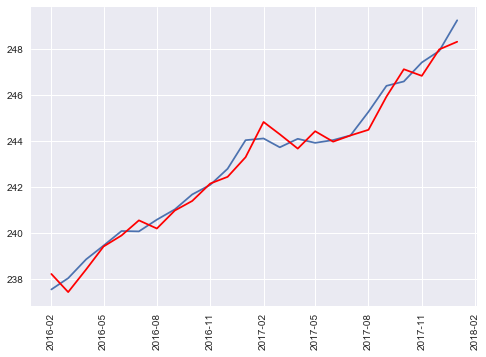

In [69]:
cpi1_error = mean_squared_error(cpi1_res.actual, cpi1_res.predicted)
print('Test MSE: {0:.3f}'.format(cpi1_error))

# plot
plt.plot(cpi1_res.actual)
plt.plot(cpi1_res.predicted, color='red')
plt.xticks(rotation = 90)
plt.savefig('cpi_mse_1')
plt.show()

In [70]:
# MASE for CPI 1
mase_cpi1 = mase(cpi1_train, cpi1_res.actual, cpi1_res.predicted)
print('CPIAUCSL MASE: {0:.3f}'.format(mase_cpi1))

CPIAUCSL MASE: 0.736


In [71]:
# MAPE for CPI 1
mape_cpi1 = mape(cpi1_res.actual, cpi1_res.predicted)
print('CPIAUCSL MAPE: {0:.3f}'.format(mape_cpi1))

CPIAUCSL MAPE: 0.170


In [72]:
output_cpi1 = model_cpi1_fit.forecast(steps = 4, alpha = 0.01)
output_cpi1[0]

array([ 250.07258417,  250.64617627,  251.0926301 ,  251.4754436 ])

    Steps = 4: 
    This is because each step represent one month. The stock market index data that I have ends with May 2018, therefore I decided to forecast the inflation of May, 2018. 

# CPI w/ CPILFESL (CPI 2)

In [73]:
# choose the a CPI to work with
cpi2 = cpi_monthly['CPILFESL'].copy()

# reverse the order of the dates
# start with index [0]  => 2018
# and end with => 2008
cpi2 = cpi2.sort_index(ascending = True)
cpi2.head()

DATE
2008-01-01    213.771
2008-02-01    213.939
2008-03-01    214.420
2008-04-01    214.560
2008-05-01    214.936
Name: CPILFESL, dtype: float64

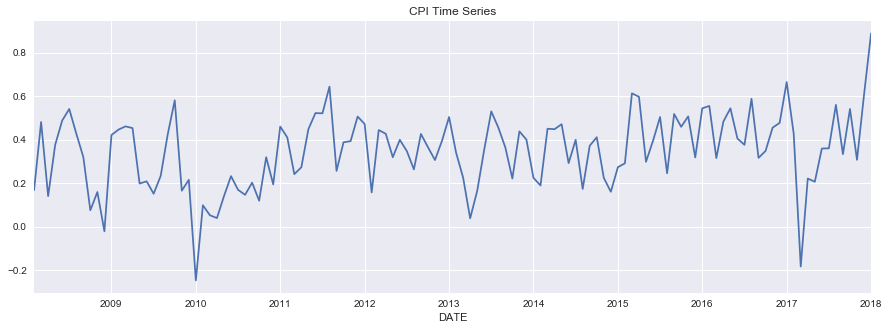

In [74]:
# set graph size
plt.figure(figsize = (15,5))

# plot the differences to show stationarity
diff_2 = (cpi2 - cpi2.shift()).dropna()

diff_2.plot()
plt.title('CPI Time Series')
plt.savefig('cpi_statinary_2')
plt.show()

    in comparison to the previous stationary graph for CPIAUSCL, CPILFESL is more consistent. There is less variations, hence more stationary

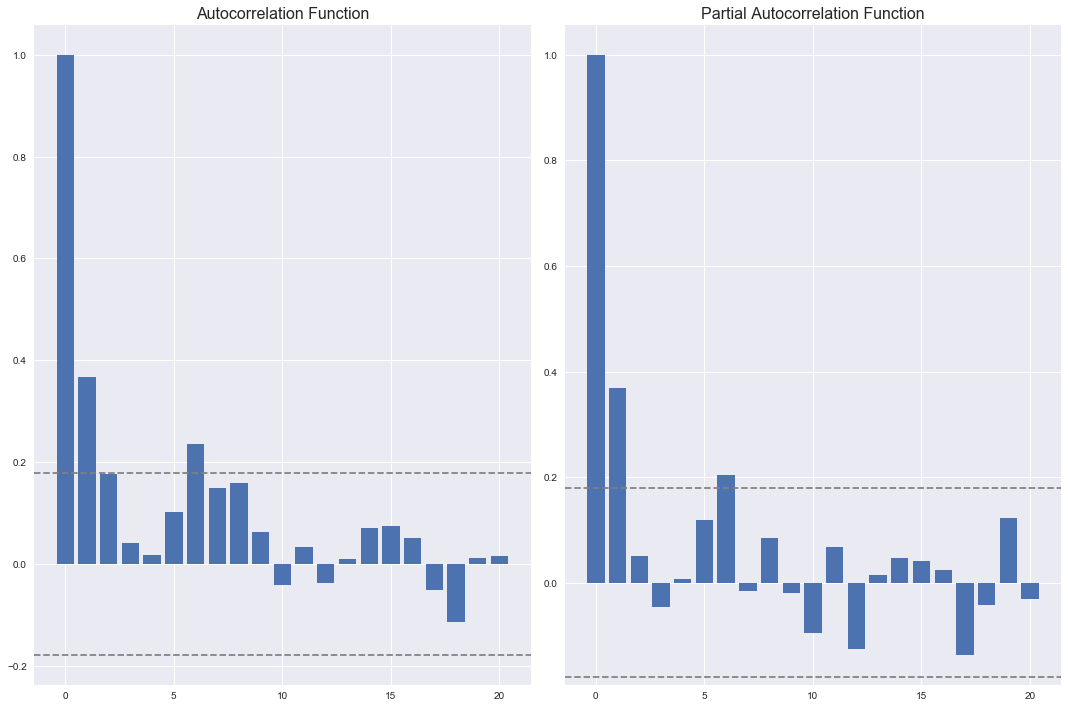

In [75]:
cpi2_lag_acf = acf(diff_2, nlags = 20)
cpi2_lag_pacf = pacf(diff_2, nlags = 20)

# set graph size
plt.figure(figsize = (15,10))

# plot ACF
plt.subplot(121)
plt.bar(range(len(cpi2_lag_acf)), cpi2_lag_acf)
plt.axhline(y = -1.96/np.sqrt(len(diff_2)),linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(diff_2)), linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize = 16)

# plot PACF
plt.subplot(122)
plt.bar(range(len(cpi2_lag_pacf)), cpi2_lag_pacf)
plt.axhline(y = -1.96/np.sqrt(len(diff_2)), linestyle='--',color='gray')
plt.axhline(y = 1.96/np.sqrt(len(diff_2)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize = 16)

plt.tight_layout()
plt.savefig('cpi_autocorr_2')
plt.show()

In [76]:
model_cpi2 = ARIMA(cpi2, order = (2,1,1))
model_cpi2_fit = model_cpi2.fit()

print(model_cpi2_fit.summary())
print('Residuals Description')
print(model_cpi2_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:             D.CPILFESL   No. Observations:                  120
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  50.902
Method:                       css-mle   S.D. of innovations              0.158
Date:                Mon, 07 May 2018   AIC                            -91.804
Time:                        09:31:23   BIC                            -77.866
Sample:                    02-01-2008   HQIC                           -86.144
                         - 01-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3487      0.025     13.924      0.000       0.300       0.398
ar.L1.D.CPILFESL    -0.3761      0.283     -1.330      0.186      -0.930       0.178
ar.L2.D.CPILFESL     0.3658 

In [77]:
# create training and test set
size = int(cpi2.shape[0] * 0.2)
cpi2_test, cpi2_train = cpi2[-size:], cpi2[:-size]
cpi2_train_set = [x for x in cpi2_train]
cpi2_prediction = list()

for t in range(len(cpi2_test)):
    model_cpi2 = ARIMA(cpi2_train_set, order = (2,1,1))
    model_cpi2_fit = model_cpi2.fit()
    output = model_cpi2_fit.forecast()
    yhat = output[0]
    cpi2_prediction.append(yhat[0])
    obs = cpi2_test[t]
    cpi2_train_set.append(obs)

cpi2_res = pd.DataFrame({'predicted': cpi2_prediction,
                         'actual': cpi2_test})
cpi2_res.head()

,actual,predicted
DATE,,
2016-02-01,245.689,245.517481
2016-03-01,246.004,246.142825
2016-04-01,246.487,246.326631
2016-05-01,247.031,246.868665
2016-06-01,247.436,247.460372


Test MSE: 0.043


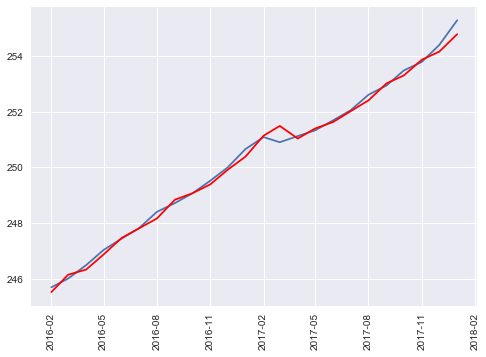

In [78]:
cpi2_error = mean_squared_error(cpi2_res.actual, cpi2_res.predicted)
print('Test MSE: {0:.3f}'.format(cpi2_error))

# plot
plt.plot(cpi2_res.actual)
plt.plot(cpi2_res.predicted, color='red')
plt.xticks(rotation = 90)
plt.savefig('cpi_mse_2')
plt.show()

In [79]:
# MASE for CPI 2
mase_cpi2 = mase(cpi2_train, cpi2_res.actual, cpi2_res.predicted)
print('CPILFESL MASE: {0:.3f}'.format(mase_cpi2))

CPILFESL MASE: 0.460


In [80]:
# MAPE for CPI 2
mape_cpi2 = mape(cpi2_res.actual, cpi2_res.predicted)
print('CPILFESL MAPE: {0:.3f}'.format(mape_cpi2))

CPILFESL MAPE: 0.061


In [81]:
# MASE for CPI 2
output_cpi2 = model_cpi2_fit.forecast(steps = 4, alpha = 0.01)
output_cpi2[0]

array([ 254.78720248,  255.20820434,  255.53195555,  255.91217406])

    CPILFESL seem to perfrom slightly better according to the MSE, MAPE, and MASE. 2 of the 3 metrics support CPILFESL, since they are smaller which mean less erroraneous and more accurate. For calculation of inflation, I want to use the outpus from CPILFESL.

# Formulas
$$ Inflation = (CPI_Current_Year - CPI_Previous_Year) \div  CPI_Previous_Year $$
http://financeformulas.net/Rate_of_Inflation.html
$$ Stock Market Return = (Index_End - Index_Start) \div  Index_Start $$
https://www.fool.com/knowledge-center/how-to-calculate-return-on-indices-in-a-stock-mark.aspx

In [82]:
# cpi of 2017
# normally calculation for cpi is using the index from the previous and current year, and the period of time is usually 
# 1 year, hence I used the index from May, 2017. This way, it will be exactly 1 year from May, 2018 (our data) 
cpi_2017 = cpi2['2017-05'][0]

# predicted valeus of cpi in May, 2018 
cpi_2018 = output_cpi2[0][3]

# calculate the inflation rate
inflation = ((cpi_2018 - cpi_2017) / cpi_2017) * 100
print('Inflation Rate:', inflation)

Inflation Rate: 1.82276522086


In [83]:
# Stock Market Index at the start of the year
start_index = nas_arima.Close['2018-01-02']

# Stock Market Index for the next 3 months
pred_index = list(output_arima[0])
end_index = np.mean(pred_index)      # will substitute this as the index for end of year

# calculate the stock market return
sm_return = (end_index - start_index) / start_index * 100
print('Stock Market Return:', sm_return)

Stock Market Return: 1.9544093146


# Black Scholes Model

##### Call Option

    stock price
    strike price
    exercise price
    volatility (historical) - https://www.investopedia.com/ask/answers/021015/how-can-you-calculate-volatility-excel.asp
    risk return rate - https://www.fool.com/knowledge-center/how-to-calculate-liquidity-premium-and-real-risk.aspx (equation)
    time (Year)

##### Data:
* https://finance.yahoo.com/quote/AAPL/history?p=AAPL - apple
* https://finance.yahoo.com/quote/AEY/history?p=AEY - aey
* https://finance.yahoo.com/quote/MBWM/history?p=MBWM - mbwm
    
    Data is from 2008 - 2018, 10 years.

In [84]:
# parse date
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# import Apple.csv
appl = pd.read_csv('AAPL.csv', parse_dates = ['Date'], index_col = 'Date', date_parser = dateparse)
aey = pd.read_csv('AEY.csv', parse_dates = ['Date'], index_col = 'Date', date_parser = dateparse)
mbwm = pd.read_csv('MBWM.csv', parse_dates = ['Date'], index_col = 'Date', date_parser = dateparse)

# number of trading days in a year
trading_days = 252 

In [85]:
# calculate the volatility of 10 days
def volat_10(dat):
    diff_10 = (dat / dat.shift() - 1).dropna()
    volatility_10 = (diff_10).std()
    volatility_10 = volatility_10 * np.sqrt(trading_days)       # 10-day period to annualized historical volatility
    
    return volatility_10;

In [86]:
# calculate the volatility of 20 days
def volat_20(dat):
    diff_20 = (dat / dat.shift() - 1).dropna()
    volatility_20 = (diff_20).std()
    volatility_20 = volatility_20 * np.sqrt(trading_days)       # 20-day period to annualized historical volatility
    
    return volatility_20;

In [87]:
# calculate the volatility of 30 days
def volat_30(dat):
    diff_30 = (dat / dat.shift() - 1).dropna()
    volatility_30 = (diff_30).std()
    volatility_30 = volatility_30 * np.sqrt(trading_days)       # 30-day period to annualized historical volatility
    
    return volatility_30;

In [88]:
# calculate volatility for Apple
apple_10 = volat_10(appl.Close[-10:])    # 10 day period
apple_20 = volat_20(appl.Close[-20:])    # 20 day period
apple_30 = volat_30(appl.Close[-30:])    # 30 day period

In [89]:
# calculate volatility for Aey
aey_10 = volat_10(aey.Close[-10:])    # 10 day period
aey_20 = volat_20(aey.Close[-20:])    # 20 day period
aey_30 = volat_30(aey.Close[-30:])    # 30 day period

In [90]:
# calculate volatility for Aey
mbwm_10 = volat_10(mbwm.Close[-10:])    # 10 day period
mbwm_20 = volat_20(mbwm.Close[-20:])    # 20 day period
mbwm_30 = volat_30(mbwm.Close[-30:])    # 30 day period

### Call Option
* Buyer, reserve the rights to buy the stocks at time of expiration but not obligated to
* Exercise Price < Stock Price, only buy stocks if this condition is satisfied

In [157]:
# set variable for values to set by the user
# set time to expiration days to a constant of 30 days or 1 month
# set strike price to be 5% less than the stock price
mon = 30
time_exp = mon / 365
exer_rate = 0.95

In [158]:
from scipy.stats import norm

def call_option(stock_price, volatility, time_exp, exer_rate, sm_return, inflation):
    exer_price = stock_price * exer_rate   # exercise price
    volat = volatility                     # volatility
    rf_rate = sm_return - inflation        # risk free rate

    # calculate d1
    call_d1 = (np.log(stock_price / exer_price) + (rf_rate + (volat **2 / 2)) *  time_exp) / (volat * np.sqrt(time_exp))

    # calculate d2
    call_d2 = (np.log(stock_price / exer_price) + (rf_rate - (volat **2 / 2)) *  time_exp) / (volat * np.sqrt(time_exp))

    # calculate Call Option
    Call = (stock_price * norm.cdf(call_d1)) - (exer_price / np.exp(rf_rate * time_exp) * norm.cdf(call_d2))
    
    return Call;

In [159]:
apple_call_10 = call_option(appl.Close[-1], apple_10, time_exp, exer_rate, sm_return, inflation)
apple_call_20 = call_option(appl.Close[-1], apple_20, time_exp, exer_rate, sm_return, inflation)
apple_call_30 = call_option(appl.Close[-1], apple_30, time_exp, exer_rate, sm_return, inflation)

print('Apple Stock Call Option: {0:.2f}'.format(apple_call_10))
print('Apple Stock Call Option: {0:.2f}'.format(apple_call_20))
print('Apple Stock Call Option: {0:.2f}'.format(apple_call_30))

Apple Stock Call Option: 13.62
Apple Stock Call Option: 13.59
Apple Stock Call Option: 13.61


In [160]:
aey_call_10 = call_option(aey.Close[-1], aey_10, time_exp, exer_rate, sm_return, inflation)
aey_call_20 = call_option(aey.Close[-1], aey_20, time_exp, exer_rate, sm_return, inflation)
aey_call_30 = call_option(aey.Close[-1], aey_30, time_exp, exer_rate, sm_return, inflation)

print('AEY Stock Call Option: {0:.2f}'.format(aey_call_10))
print('AEY Stock Call Option: {0:.2f}'.format(aey_call_20))
print('AEY Stock Call Option: {0:.2f}'.format(aey_call_30))

AEY Stock Call Option: 0.08
AEY Stock Call Option: 0.09
AEY Stock Call Option: 0.08


In [161]:
mbwm_call_10 = call_option(mbwm.Close[-1], mbwm_10, time_exp, exer_rate, sm_return, inflation)
mbwm_call_20 = call_option(mbwm.Close[-1], mbwm_20, time_exp, exer_rate, sm_return, inflation)
mbwm_call_30 = call_option(mbwm.Close[-1], mbwm_30, time_exp, exer_rate, sm_return, inflation)

print('MBWM Stock Call Option: {0:.2f}'.format(mbwm_call_10))
print('MBWM Stock Call Option: {0:.2f}'.format(mbwm_call_20))
print('MBWM Stock Call Option: {0:.2f}'.format(mbwm_call_30))

MBWM Stock Call Option: 2.22
MBWM Stock Call Option: 2.22
MBWM Stock Call Option: 2.30


    comments on the results

### Put Option
* Seller, reserve the rights to sell the stocks at time of expiration but not obligated to
* Exercise Price < Stock Price, only buy stocks if this condition is satisfied

In [162]:
def put_option(stock_price, volatility, time_exp, exer_rate, sm_return, inflation):
    exer_price = stock_price * exer_rate   # exercise price
    volat = volatility                     # volatility
    rf_rate = sm_return - inflation        # risk free rate

    # calculate d1
    put_d1 = (np.log(stock_price / exer_price) + (rf_rate + (volat **2 / 2)) *  time_exp) / (volat * np.sqrt(time_exp))

    # calculate d2
    put_d2 = (np.log(stock_price / exer_price) + (rf_rate - (volat **2 / 2)) *  time_exp) / (volat * np.sqrt(time_exp))

    # calculate Call Option
    Put =  (exer_price / np.exp(rf_rate * time_exp) * norm.cdf(-put_d2)) - (stock_price * norm.cdf(-put_d1))
    
    return Put;

In [163]:
apple_put_10 = put_option(appl.Close[-1], apple_10, time_exp, exer_rate, sm_return, inflation)
apple_put_20 = put_option(appl.Close[-1], apple_20, time_exp, exer_rate, sm_return, inflation)
apple_put_30 = put_option(appl.Close[-1], apple_30, time_exp, exer_rate, sm_return, inflation)

print('Apple Stock Put Option: {0:.2f}'.format(apple_put_10))
print('Apple Stock Put Option: {0:.2f}'.format(apple_put_20))
print('Apple Stock Put Option: {0:.2f}'.format(apple_put_30))

Apple Stock Put Option: 2.55
Apple Stock Put Option: 2.52
Apple Stock Put Option: 2.54


In [164]:
aey_put_10 = put_option(aey.Close[-1], aey_10, time_exp, exer_rate, sm_return, inflation)
aey_put_20 = put_option(aey.Close[-1], aey_20, time_exp, exer_rate, sm_return, inflation)
aey_put_30 = put_option(aey.Close[-1], aey_30, time_exp, exer_rate, sm_return, inflation)

print('AEY Stock Put Option: {0:.2f}'.format(aey_put_10))
print('AEY Stock Put Option: {0:.2f}'.format(aey_put_20))
print('AEY Stock Put Option: {0:.2f}'.format(aey_put_30))

AEY Stock Put Option: 0.00
AEY Stock Put Option: 0.01
AEY Stock Put Option: 0.01


In [165]:
mbwm_put_10 = put_option(mbwm.Close[-1], mbwm_10, time_exp, exer_rate, sm_return, inflation)
mbwm_put_20 = put_option(mbwm.Close[-1], mbwm_20, time_exp, exer_rate, sm_return, inflation)
mbwm_put_30 = put_option(mbwm.Close[-1], mbwm_30, time_exp, exer_rate, sm_return, inflation)

print('MBWM Stock Put Option: {0:.2f}'.format(mbwm_put_10))
print('MBWM Stock Put Option: {0:.2f}'.format(mbwm_put_20))
print('MBWM Stock Put Option: {0:.2f}'.format(mbwm_put_30))

MBWM Stock Put Option: 0.10
MBWM Stock Put Option: 0.09
MBWM Stock Put Option: 0.17


# Put-Call Parity
checking for the calculation accuracy of the black scholes model
$$ value_P = value_C + strike_P~/~exp~(risk~free~rate * time~exp) - stock_P $$

In [166]:
def parity(value_p, value_c, stock_price, time_exp, exer_rate, sm_return, inflation):
    exer_price = stock_price * exer_rate   # exercise price
    rf_rate = sm_return - inflation        # risk free rate
    
    ans = value_c + (exer_price / np.exp(rf_rate * time_exp)) - stock_price
    
    #check if ans is equal to put value
    if np.round(value_p, 2) == np.round(ans, 2):
        return('Calculation is Right')
    else:
        return('Calculation is Wrong')
    

In [167]:
# check calculation
apple_30_parity = parity(apple_put_30, apple_call_30, appl.Close[-1], time_exp, exer_rate, sm_return, inflation)
print(apple_30_parity)

Calculation is Right


    Now that we know the calculation of the Black-Scholes Model is indeed correct for both call and put option, let's analyze the results

# Interpertation of Results

    Let's start with an example: the stock price of Apple with 30 days of volatility.

In [168]:
def decision(stock_price, exer_rate, call_value, put_value):
    exer_price = stock_price * exer_rate     # strike price
    
    intrinsic = np.abs((stock_price - exer_price))   #intrinsic value (exist only if call/put value is higher)
    
    call_pre = call_value - intrinsic  # speculated premium value (profit) for call and put options
    put_pre = put_value - intrinsic    
    
    if call_pre < 0:
        call_pre = 0
    
    if put_pre < 0:
        put_pre = 0
        
    return print('Call Premium: {0:.2f} \nPut Premium:  {1:.2f}'.format(call_pre, put_pre));

In [169]:
# when strike price is lower (0.95 of stock price)
result_lower_strike = decision(appl.Close[-1], exer_rate, apple_call_30, apple_put_30)

Call Premium: 4.42 
Put Premium:  0.00


In [156]:
# when strike price is higher (1.05 of stock price)
result_higher_stike = decision(appl.Close[-1], exer_rate, apple_call_30, apple_put_30)

Call Premium: 0.00 
Put Premium:  1.94


    When the strike price is smaller than the stock price it is better to invest in the call option and when the strike price is larger than the stock price it is better to invest in the put option. However comparing the difference in the premium values of both options, the result is expected that Call Option is more profittable in the current market since the Stock Indexes are showing continous growth with no signs of dropping.